In [1]:
import pandas as pd 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

import sys
#sys.path.append("C:/git/climate-question-answering")
sys.path.append("/home/dora/climate-question-answering")

from dotenv import load_dotenv
load_dotenv()

True

# Import objects

In [2]:
from climateqa.engine.llm import get_llm
llm = get_llm(provider="openai")

In [3]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("small")
# from rerankers import Reranker
# # Specific flashrank model.
# # reranker = Reranker('ms-marco-TinyBERT-L-2-v2', model_type='flashrank')
# # reranker = Reranker('ms-marco-MiniLM-L-12-v2', model_type='flashrank')
# # reranker = Reranker('cross-encoder/ms-marco-MiniLM-L-4-v2', model_type='cross-encoder')
# # reranker = Reranker("mixedbread-ai/mxbai-rerank-xsmall-v1", model_type='cross-encoder')
# # reranker = Reranker("mixedbread-ai/mxbai-rerank-xsmall-v1", model_type='cross-encoder')
# reranker = Reranker("cohere", lang='en', api_key = "XXX")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading TransformerRanker model mixedbread-ai/mxbai-rerank-xsmall-v1
No device set
Using device cpu
No dtype set
Device set to `cpu`, setting dtype to `float32`
Using dtype torch.float32
Loaded model mixedbread-ai/mxbai-rerank-xsmall-v1
Using device cpu.
Using dtype torch.float32.


In [4]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore
from climateqa.engine.embeddings import get_embeddings_function
from climateqa.engine.retriever import ClimateQARetriever

embeddings_function = get_embeddings_function()
vectorstore = get_pinecone_vectorstore(embeddings_function)

Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(


In [6]:
import torch

In [7]:
torch.cuda.is_available()

False

# Semantic Routing

In [8]:
# £from climateqa.engine.chains.intent_routing import make_intent_router_chain
from climateqa.engine.chains.intent_categorization import make_intent_categorization_chain

In [9]:
# router_chain = make_intent_router_chain(llm)
router_chain = make_intent_categorization_chain(llm)

In [10]:
# for question in SAMPLE_QUESTIONS:
#     output = router_chain.invoke({"input":question})
#     print(question)
#     print(output)
#     print("-"*100)
#     break

In [11]:
router_chain.invoke({"input":"Which industries have the highest GHG emissions?"})

{'intent': 'search'}

# Query Rewriter

In [12]:
from climateqa.engine.chains.query_transformation import make_query_rewriter_chain,make_query_decomposition_chain
from climateqa.engine.chains.translation import make_translation_chain

In [13]:
rewriter_chain = make_query_rewriter_chain(llm)
translation_chain = make_translation_chain(llm)
decomposition_chain = make_query_decomposition_chain(llm)
# router_chain = make_intent_router_chain(llm)
router_chain = make_intent_categorization_chain(llm)

In [14]:
def transform_query(user_input):
    
    state = {"user_input":user_input}
    
    # Route
    output_router = router_chain.invoke({"input":user_input})
    if "language" not in output_router: output_router["language"] = "English" # for robustness
    state.update(output_router)
    
    # Translation
    if output_router["language"].lower() != "english":
        translation = translation_chain.invoke({"input":user_input})
        state["query"] = translation["translation"]
    else:
        state["query"] = user_input
        
    # Decomposition
    decomposition_output = decomposition_chain.invoke({"input":state["query"]})
    state.update(decomposition_output)
    
    # Query Analysis
    questions = []
    for question in state["questions"]:
        question_state = {"question":question}
        analysis_output = rewriter_chain.invoke({"input":question})
        question_state.update(analysis_output)
        questions.append(question_state)
    state["questions"] = questions
    
    return state

In [15]:
question = "Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications ?"
#question = "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
#question = "I need to search the president of the United States, find their age, then find how old they will be in June 2023."
#question = "What does Morrison argue about IK and LK on internal migration ?"
state = transform_query(question)
state

{'user_input': 'Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications ?',
 'language': 'French',
 'intent': 'search',
 'query': "Honestly, I'm not sure what we're talking about here, who are the members of the IPCC actually? And what are their latest publications?",
 'questions': [{'question': 'Who are the members of the IPCC?',
   'sources': ['IPCC']},
  {'question': 'What are the latest publications of the IPCC?',
   'sources': ['IPCC']}]}

In [16]:
questions = [
    "Super thanks, Which industries have the highest GHG emissions?",
    "How do you compare the view on biodiversity between the IPCC and IPBES ?",
    "Est-ce que l'IA a un impact sur l'environnement ?",
    "Que dit le GIEC sur l'impact de l'IA",
    "Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications ?",
    "Ok that's nice, but I don't really understand. What is the impact of El Nino ?",
    "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?",
    "Which industries have the highest GHG emissions?",
    "What are invasive alien species and how do they threaten biodiversity and ecosystems?",
    "Are human activities causing global warming?",
    "What is the motivation behind mining the deep seabed?",
    "Tu peux m'écrire un poème sur le changement climatique ?",
    "Tu peux m'écrire un poème sur les bonbons ?",
    "What will be the temperature in 2100 in Strasbourg?",
    "C'est quoi le lien entre biodiversity and changement climatique ?",
    "Can you tell me more about ESRS2 ?"
]

question = questions[0]
question

'Super thanks, Which industries have the highest GHG emissions?'

In [17]:
question = "Very nice thank you, What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
output = rewriter_chain.invoke({"input":question})
output

{'sources': ['IPCC']}

In [19]:
for question in questions:
    print(question)
    output = transform_query(question)
    print(output)
    print("-"*100)

Super thanks, Which industries have the highest GHG emissions?
{'user_input': 'Super thanks, Which industries have the highest GHG emissions?', 'intent': 'search', 'language': 'English', 'query': 'Super thanks, Which industries have the highest GHG emissions?', 'questions': [{'question': 'What are the industries with the highest greenhouse gas emissions?', 'sources': ['IPCC']}]}
----------------------------------------------------------------------------------------------------
How do you compare the view on biodiversity between the IPCC and IPBES ?
{'user_input': 'How do you compare the view on biodiversity between the IPCC and IPBES ?', 'intent': 'search', 'language': 'English', 'query': 'How do you compare the view on biodiversity between the IPCC and IPBES ?', 'questions': [{'question': 'What is the view on biodiversity according to the IPCC?', 'sources': ['IPCC']}, {'question': 'What is the view on biodiversity according to the IPBES?', 'sources': ['IPBES']}, {'question': 'What ar

In [18]:
rewriter_chain.invoke({"input":question})

{'sources': ['IPCC']}

# Langgraph
Inspired from https://colab.research.google.com/drive/1WemHvycYcoNTDr33w7p2HL3FF72Nj88i?usp=sharing#scrollTo=YJ77ZCzkiGTL

## Graph

In [5]:
from climateqa.engine.graph import make_graph_agent,display_graph
agent = make_graph_agent(llm,vectorstore,reranker)

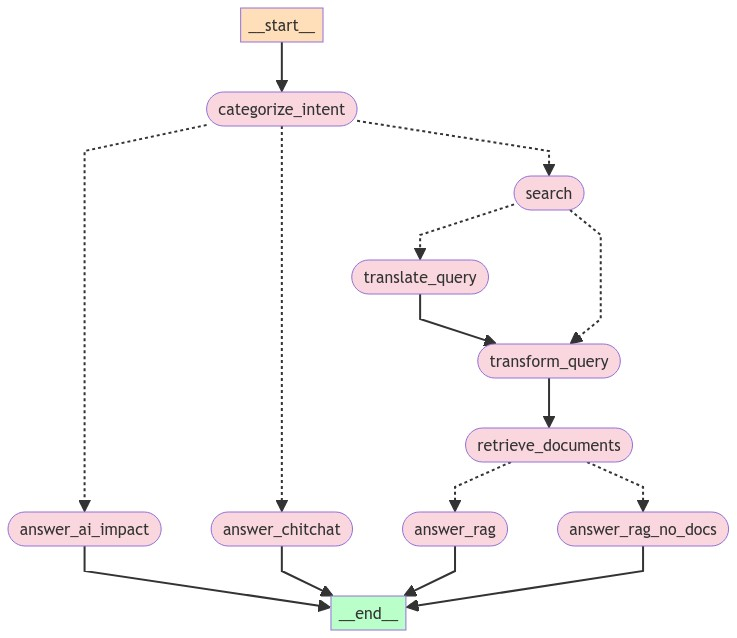

In [6]:
display_graph(agent)

In [7]:
verbose = False
question = "What evidence do we have of climate change?"

steps_display = {
    "categorize_intent":("... Analyzing user message",True),
    "transform_query":("... Thinking step by step to answer the question",True),
    "retrieve_documents":("... Searching in the knowledge base",False),
}

def display_steps(event):

    for event_name,(event_description,display_output) in steps_display.items():
        if event["name"] == event_name:
            if event["event"] == "on_chain_start":
                print(event_description)
            elif event["event"] == "on_chain_end":
                if display_output:
                    print(event["data"]["output"])

async for event in agent.astream_events({"user_input":question,"sources_input":["auto"],"audience":"experts"},version = "v1"):

    if verbose:
        print(event)
        print("-"*50)
    else:
    
        if event["event"] == "on_chat_model_stream":
            print(event["data"]["chunk"].content,end = "")

        if event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
            docs = event["data"]["output"]["documents"]
            
        display_steps(event)

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


... Analyzing user message
{'intent': 'search', 'language': 'English', 'query': 'What evidence do we have of climate change?'}
... Thinking step by step to answer the question
{'questions': [{'question': 'What are the key indicators of climate change?', 'sources': ['IPCC']}, {'question': 'How do scientists gather evidence of climate change?', 'sources': ['IPCC']}, {'question': 'What data supports the existence of climate change?', 'sources': ['IPCC']}]}


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


... Searching in the knowledge base


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


The evidence for climate change is supported by a broad range of indicators that collectively show rapid changes across various components of the global climate system [Doc 2, Doc 3]. These changes are observed in the atmosphere, ocean, cryosphere, and biosphere, indicating a coherent picture of a warming world [Doc 2, Doc 3]. 

- Key climate indicators have been selected across different domains, such as atmospheric, oceanic, cryospheric, and biospheric, to provide a synthesis of climate system evolution [Doc 1].
- Observations over the past century show rapid changes in many indicators of the climate system, with consistent evidence pointing to a world that has warmed rapidly [Doc 5].
- The IPCC reports highlight that warming of the climate system is unequivocal, with unprecedented changes observed since the 1950s in all components of the climate system [Doc 7].
- Multiple lines of evidence indicate that recent large-scale climatic changes are unprecedented in a multi-millennial cont

: 

In [23]:
docs

[Document(page_content='Defining a key set of climate indicators\n <Section-header> Defining a key set of climate indicators </Section-header> \n\nDefining a key set of climate indicators\nKey climate indicators should constitute a finite set of distinct variables and/or metrics that may collectively point to important overall \r\nchanges in the climate system that provide a synthesis of climate system evolution and are of broad societal relevance. Key indicators \r\nhave been selected across the atmospheric, oceanic, cryospheric and biospheric domains, with land as a cross-cutting component. These \r\nindicators, and their use across Chapters 2, 3 and 4, as well as the broader report, are summarized in Cross-Chapter Box 2.2, Table 1. \r\nAll selected indicators are Essential Climate Variables as defined by the Global Climate Observing System (Bojinski et al., 2014).\n <Section-header> Defining a key set of climate indicators </Section-header>', metadata={'chunk_type': 'text', 'documen

In [21]:
output = await agent.ainvoke({"user_input":"C'est quoi l'empreinte carbone de l'IA"})
output

{'user_input': "C'est quoi l'empreinte carbone de l'IA",
 'language': 'French',
 'intent': 'ai_impact',
 'query': "C'est quoi l'empreinte carbone de l'IA",
 'answer': "L'impact environnemental de l'intelligence artificielle (IA) n'est pas couvert spécifiquement par les rapports du GIEC ou de l'IPBES. Cependant, il existe des recherches récentes sur ce sujet. Par exemple, vous pouvez consulter le travail de l'experte en IA et climat, Sasha Luccioni, qui a publié plusieurs articles sur l'empreinte carbone de l'IA, notamment sur le coût énergétique de l'inférence des modèles d'IA et sur l'estimation de l'empreinte carbone de l'entraînement de grands modèles de langage.\n\nDe plus, il existe des outils tels que CodeCarbon et Ecologits qui peuvent vous aider à calculer l'empreinte carbone de vos modèles d'IA. Si vous souhaitez en savoir plus sur l'empreinte carbone de l'IA, je vous recommande de consulter ces ressources et ces outils."}

: 

## Test simple route chains

In [25]:
from climateqa.engine.chains.answer_chitchat import make_chitchat_chain
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_chain

chitchat_chain = make_chitchat_chain(llm)
ai_impact_chain = make_ai_impact_chain(llm)

In [26]:
async for event in ai_impact_chain.astream_events({"question":"Mais c'est quoi l'empreinte carbone de cet outil, ça doit consommer pas mal ..."},version = "v1"):
    if event["event"] == "on_chain_stream":
        print(event["data"]["chunk"],end = "")

L'impact environnemental des outils basés sur l'intelligence artificielle (IA) n'est pas couvert par les rapports du GIEC ou de l'IPBES. Cependant, il existe des recherches récentes sur ce sujet. Par exemple, le scientifique spécialisé en IA et climat, Sasha Luccioni, a publié des articles sur l'empreinte carbone des modèles d'IA, notamment sur la formation de grands modèles de langage.

Si vous souhaitez en savoir plus sur l'empreinte carbone des outils basés sur l'IA, je vous recommande de consulter les travaux de Sasha Luccioni, en particulier les articles suivants :
- "Power Hungry Processing: Watts Driving the Cost of AI Deployment?" - https://arxiv.org/abs/2311.16863
- "Counting Carbon: A Survey of Factors Influencing the Emissions of Machine Learning" - https://arxiv.org/abs/2302.08476
- "Estimating the Carbon Footprint of BLOOM, a 176B Parameter Language Model" - https://arxiv.org/abs/2211.02001

De plus, il existe des outils tels que CodeCarbon (https://github.com/mlco2/codeca

In [27]:
async for event in chitchat_chain.astream_events({"question":"Vas y blbablablala"},version = "v1"):
    if event["event"] == "on_chain_stream":
        print(event["data"]["chunk"],end = "")

Désolé, je ne peux répondre qu'aux questions liées à l'environnement et au climat. N'hésitez pas à poser une autre question sur ces sujets!

In [28]:
from langchain.schema import Document
from langgraph.graph import END, StateGraph

: 

## Retriever & Reranker

In [1]:
query = "Is global warming caused by humans?"

retriever = ClimateQARetriever(
    vectorstore=vectorstore,
    sources = ["IPCC"],
    # reports = ias_reports,
   min_size = 200,
   k_summary = 5,k_total = 100,
   threshold = 0.5,
)

docs_question = retriever.get_relevant_documents(query)
len(docs_question)

NameError: name 'ClimateQARetriever' is not defined

In [86]:
%%time
from scipy.special import expit, logit

def rerank_docs(reranker,docs,query):
    
    # Get a list of texts from langchain docs
    input_docs = [x.page_content for x in docs]
    
    # Rerank using rerankers library
    results = reranker.rank(query=query, docs=input_docs)

    # Prepare langchain list of docs
    docs_reranked = []
    for result in results.results:
        doc_id = result.document.doc_id
        doc = docs[doc_id]
        doc.metadata["rerank_score"] = result.score
        doc.metadata["query_used_for_retrieval"] = query
        docs_reranked.append(doc)
    return docs_reranked

docs_reranked = rerank_docs(reranker,docs_question,query)

CPU times: total: 1.97 s
Wall time: 681 ms


In [87]:
docs_reranked[0]

Document(page_content='Observed Warming and its Causes\nA.1 Human activities, principally through emissions of greenhouse gases, have unequivocally \r\ncaused global warming, with global surface temperature reaching 1.1degC above 1850-1900 \r\nin 2011-2020. Global greenhouse gas emissions have continued to increase, with unequal \r\nhistorical and ongoing contributions arising from unsustainable energy use, land use and \r\nland-use change, lifestyles and patterns of consumption and production across regions, \r\nbetween and within countries, and among individuals (high confidence). {2.1, Figure 2.1, \r\nFigure 2.2}', metadata={'chunk_type': 'text', 'document_id': 'document10', 'document_number': 10.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 36.0, 'name': 'Synthesis report of the IPCC Sixth Assesment Report AR6', 'num_characters': 587.0, 'num_tokens': 130.0, 'num_tokens_approx': 142.0, 'num_words': 107.0, 'page_number': 10, 'releas

In [88]:
def divide_into_parts(target, parts):
    # Base value for each part
    base = target // parts
    # Remainder to distribute
    remainder = target % parts
    # List to hold the result
    result = []
    
    for i in range(parts):
        if i < remainder:
            # These parts get base value + 1
            result.append(base + 1)
        else:
            # The rest get the base value
            result.append(base)
    
    return result

divide_into_parts(15,3)

[5, 5, 5]

In [ ]:
questions = 

In [133]:
state = {'query': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?",
 'questions': [{'question': "What role do cloud formations play in modulating the Earth's radiative balance?",
   'sources': ['IPCC']},
  {'question': 'How are cloud formations represented in current climate models?',
   'sources': ['IPCC']}]}

In [177]:
state = {'query': "What does Morrison argue about the role of IK and LK ?",
 'questions': [{'question': "How is the manga One Piece cited in the IPCC",
   'sources': ['IPCC']}]}

In [178]:
import sys
import os
from contextlib import contextmanager

@contextmanager
def suppress_output():
    # Open a null device
    with open(os.devnull, 'w') as devnull:
        # Store the original stdout and stderr
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        # Redirect stdout and stderr to the null device
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            # Restore stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [179]:
def retrieve_documents(state):
    
    POSSIBLE_SOURCES = ["IPCC","IPBES","IPOS","OpenAlex"]
    questions = state["questions"]
    
    # Use sources from the user input or from the LLM detection
    sources_input = state["sources_input"] if "sources_input" in state else ["auto"]
    auto_mode = "auto" in sources_input
    
    # Constants
    k_final = 15
    k_before_reranking = 100
    k_summary = 5
    rerank_by_question = True
    
    # There are several options to get the final top k
    # Option 1 - Get 100 documents by question and rerank by question
    # Option 2 - Get 100/n documents by question and rerank the total
    if rerank_by_question:
        k_by_question = divide_into_parts(k_final,len(questions))
    
    docs = []
    
    for i,q in enumerate(questions):
        
        sources = q["sources"]
        question = q["question"]
        
        # If auto mode, we use the sources detected by the LLM
        if auto_mode:
            sources = [x for x in sources if x in POSSIBLE_SOURCES]
            
        # Otherwise, we use the config
        else:
            sources = sources_input
            
        # Search the document store using the retriever
        # Configure high top k for further reranking step
        retriever = ClimateQARetriever(
            vectorstore=vectorstore,
            sources = sources,
            # reports = ias_reports,
           min_size = 200,
           k_summary = k_summary,k_total = k_before_reranking,
           threshold = 0.5,
        )
        docs_question = retriever.get_relevant_documents(question)
        
        # Rerank
        with suppress_output():
            docs_question = rerank_docs(reranker,docs_question,question)
        
        # If rerank by question we select the top documents for each question
        if rerank_by_question:
            docs_question = docs_question[:k_by_question[i]]
            
        # Add sources used in the metadata
        for doc in docs_question:
            doc.metadata["sources_used"] = sources
        
        # Add to the list of docs
        docs.extend(docs_question)
        
    # Sorting the list in descending order by rerank_score
    # Then select the top k
    docs = sorted(docs, key=lambda x: x.metadata["rerank_score"], reverse=True)
    docs = docs[:k_final]
    
    new_state = {"documents":docs}
    return new_state

def search(state):
    return {}

In [180]:
%%time
output = retrieve_documents(state)

CPU times: total: 1.64 s
Wall time: 3.23 s


In [181]:
rerank_scores = np.array([doc.metadata["rerank_score"] for doc in output["documents"]])
print(rerank_scores)
print(np.mean(rerank_scores))

[0.20497774 0.20197058 0.20149879 0.16000335 0.1522842  0.14817041
 0.14743239 0.1468197  0.14330755 0.13432105 0.12885363 0.12517229
 0.12262824 0.12241826 0.12210386]
0.15079746933333335


In [182]:
for doc in output["documents"]:
    print(doc)
    print("")

page_content='This Technical Summary should be cited as:\nIPCC, 2019: Technical Summary [H.-O. Portner, D.C. Roberts, V. Masson-Delmotte, P. Zhai, E. Poloczanska, K. Mintenbeck, \r\nM. Tignor, A. Alegria, M. Nicolai, A. Okem, J. Petzold, B. Rama, N.M. Weyer (eds.)]. In: IPCC Special Report on the \r\nOcean and Cryosphere in a Changing Climate [H.- O. Portner, D.C. Roberts, V. Masson-Delmotte, P. Zhai, M. Tignor, \r\nE. Poloczanska, K. Mintenbeck, A. Alegria, M. Nicolai, A. Okem, J. Petzold, B. Rama, N.M. Weyer (eds.)]. Cambridge \r\nUniversity Press, Cambridge, UK and New York, NY, USA, pp. 39-69. https://doi.org/10.1017/9781009157964.002' metadata={'chunk_type': 'text', 'document_id': 'document14', 'document_number': 14.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 34.0, 'name': 'Technical Summary. In: IPCC Special Report on the Ocean and Cryosphere in a Changing Climate', 'num_characters': 623.0, 'num_tokens': 237.0, 'num_tokens_app

## Create the RAG

In [ ]:

# async def answer_ai_impact(state,config):
#     answer = await ai_impact_chain.ainvoke({"question":state["user_input"]},config)
#     return {"answer":answer}
            
async def answer_rag(state):
    
    # Get the docs
    docs = state["documents"]
    
    # Compute the trust average score
    rerank_scores = np.array([doc.metadata["rerank_score"] for doc in docs])
    trust_score = np.mean(rerank_scores)
    
    # 
    answer = "\n".join([x["question"] for x in state["questions"]])
    return {"answer":answer}

## Test the graph

In [105]:
# question = "Tu penses quoi de Shakespeare ?"
question = "C'est quoi la recette de la tarte aux pommes ?"
question = "C'est quoi l'impact de ChatGPT ?"
question = "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"

async for event in app.astream_events({"user_input": question,"sources":["auto"]}, version="v1"):
    if event["event"] == "on_chat_model_stream":
        token = event["data"]["chunk"].content
        print(token,end = "")
        
    print(event)
    print("")

{'event': 'on_chain_start', 'run_id': '54411858-94b4-423d-933e-45e86a7d6c4b', 'name': 'LangGraph', 'tags': [], 'metadata': {}, 'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?", 'sources': ['auto']}}}

{'event': 'on_chain_start', 'name': '__start__', 'run_id': '96e10c35-0088-454b-928c-8eda40e544a9', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {}, 'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?", 'sources': ['auto']}}}

{'event': 'on_chain_end', 'name': '__start__', 'run_id': '96e10c35-0088-454b-928c-8eda40e544a9', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {}, 'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


CATEGORIZE {'intent': 'search', 'language': 'English'}
{'event': 'on_chain_start', 'name': 'ChannelWrite<route_input_message,user_input,language,intent,query,questions,answer,audience,sources_input>', 'run_id': '09cda419-7333-4bf6-aeb7-385ee456f1d9', 'tags': ['seq:step:2', 'langsmith:hidden'], 'metadata': {}, 'data': {'input': {'intent': 'search', 'language': 'English'}}}

{'event': 'on_chain_end', 'name': 'ChannelWrite<route_input_message,user_input,language,intent,query,questions,answer,audience,sources_input>', 'run_id': '09cda419-7333-4bf6-aeb7-385ee456f1d9', 'tags': ['seq:step:2', 'langsmith:hidden'], 'metadata': {}, 'data': {'input': {'intent': 'search', 'language': 'English'}, 'output': {'intent': 'search', 'language': 'English'}}}

{'event': 'on_chain_start', 'name': 'route_entry_point', 'run_id': '478ecc36-08b2-4732-8e70-6efc0fcfc22f', 'tags': ['seq:step:3'], 'metadata': {}, 'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud formations pla

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chain_start', 'name': 'ChannelWrite<transform_query,user_input,language,intent,query,questions,answer,audience,sources_input>', 'run_id': 'f0d11fc9-cdc0-4c51-8576-4fa59b668d17', 'tags': ['seq:step:2', 'langsmith:hidden'], 'metadata': {}, 'data': {'input': {'query': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?", 'questions': [{'question': 'What are the main factors contributing to climate change?', 'sources': ['IPCC']}, {'question': 'How does human activity impact biodiversity?', 'sources': ['IPBES']}, {'question': 'What are the key findings of the latest IPCC report?', 'sources': ['IPCC']}]}}}

{'event': 'on_chain_end', 'name': 'ChannelWrite<transform_query,user_input,language,intent,query,questions,answer,audience,sources_input>', 'run_id': 'f0d11fc9-cdc0-4c51-8576-4fa59b668d17', 'tags': ['seq:step:2', 'langsmith:hidden'], 'metadata': {}, 'data'

TypeError: argument of type 'NoneType' is not iterable